# Oversampled FWHM

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def psf2d(ksp, oversamp=16, timemode=0,phase = None):
    """
    Adapted from BH RAD229 Code Lecture 13
    """
    if len(ksp.shape) == 1:
        ksp = np.outer(ksp, np.ones_like(ksp))
    elif len(ksp.shape) != 2:
        raise ValueError("ksp must be 1D or 2D array.")

    if phase is not None:
        ksp = ksp.astype('complex')
        ksp *= phase
        
    y, x = ksp.shape
    
    if timemode == 1:
        ksp = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(ksp, axes=1), axis=1), axis=1)
    
    ki = ksp.copy()
    ki = np.pad(ki, ((0, oversamp*y - y), (0, oversamp*x - x)), mode='constant')
    ki = np.roll(np.roll(ki, int((oversamp/2-0.5)*y), axis=0), int((oversamp/2-0.5)*x), axis=1)

    im = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(ki)))
    im = im / np.max(np.abs(im))  # Normalize


    # Calculate FWHM
    max_val = np.max(np.abs(im))
    half_max = max_val / 2
    idx_above_half_max = np.where(np.abs(im) >= half_max)
    fwhm_y = (np.max(idx_above_half_max[0]) - np.min(idx_above_half_max[0])) / oversamp
    fwhm_x = (np.max(idx_above_half_max[1]) - np.min(idx_above_half_max[1])) / oversamp

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    axs[0, 0].imshow(np.abs(ksp), cmap='gray',vmin = 0, vmax = 1)
    axs[0, 0].set_title('k-space')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(np.abs(ksp[y//2-8:y//2+8, x//2-8:x//2+8]), cmap='gray',vmin = 0, vmax = 2)
    axs[0, 1].set_title('Central k-space')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(np.log(1+np.abs(im)), cmap='gray')
    axs[1, 0].set_title('PSF Image (log scale)')
    axs[1, 0].axis('off')

    npix = 8
    tt = f'Central PSF {npix} x {npix} pixels\nFWHM_y: {fwhm_y}, FWHM_x: {fwhm_x}'
    cim = im[y*oversamp//2-npix*oversamp//2:y*oversamp//2+npix*oversamp//2, x*oversamp//2-npix*oversamp//2:x*oversamp//2+npix*oversamp//2]
    axs[1, 1].imshow(np.abs(cim), cmap='gray')
    axs[1, 1].set_title(tt)
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    return fwhm_x, fwhm_y, 
    
import numpy as np

def define_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, partial_fourier=1):
    sampling_pattern = np.zeros((starting_size, starting_size))
    start_x = (starting_size - pattern_size_x) // 2
    end_x = start_x + pattern_size_x
    start_y = (starting_size - pattern_size_y) // 2
    end_y = start_y + pattern_size_y
    
    sampling_pattern[start_y:end_y, start_x:end_x] = 1
    if partial_fourier < 1:
        pf_factor = int(partial_fourier * pattern_size_y)
        sampling_pattern[start_y: end_y -  pf_factor, :] = 0
    
    return sampling_pattern


Fully Sampled


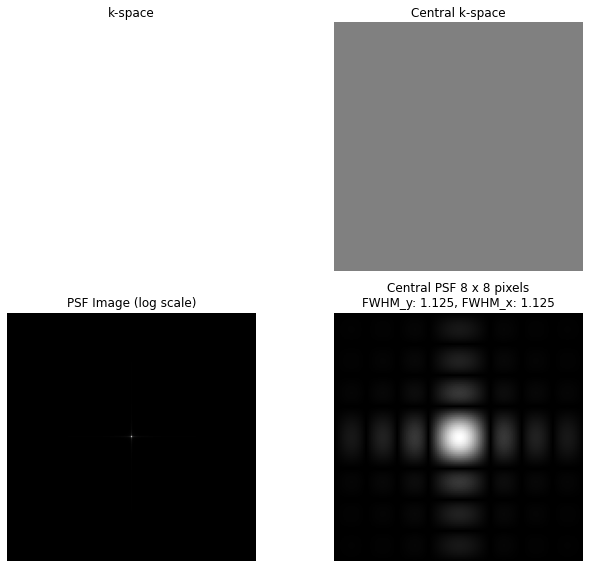

PF = 1.00, Ny = 256


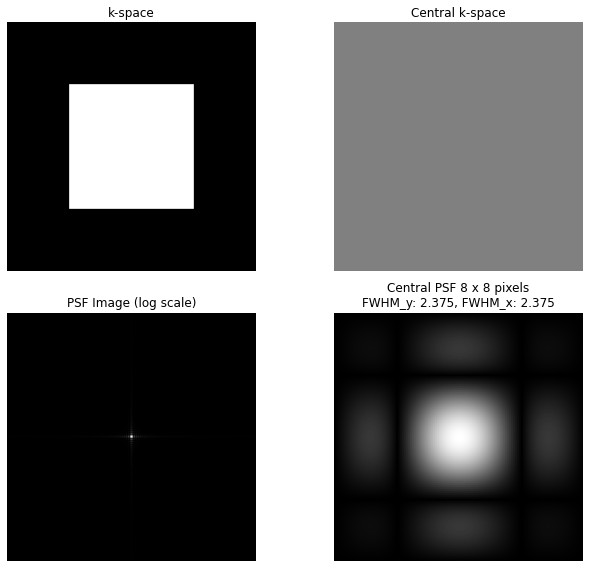

PF = 0.75, Ny = 256


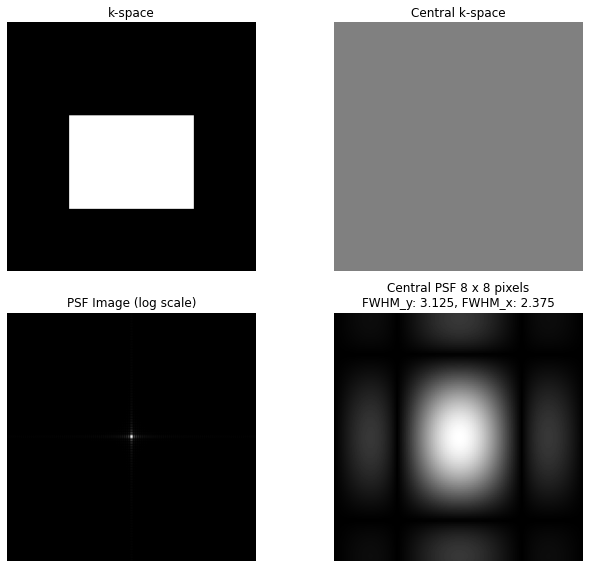

PF = 1.00, Ny = 256


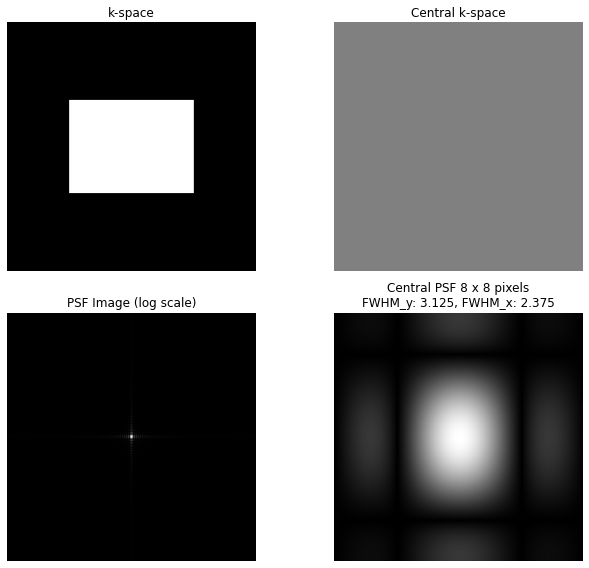

In [44]:
# Example usage:
starting_size = 256
pattern_size_x = 128
pattern_size_y = 128

# Fully Sampled Case
print('Fully Sampled')
fwhm_x, fwhm_y = psf2d(np.ones((starting_size, starting_size)))

# Undersampled Cases Below
partial_fourier = 1
sampling_pattern = define_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, partial_fourier)
print('PF = {:.2f}, Ny = {:.0f}'.format(partial_fourier, sampling_pattern.shape[-1]))
fwhm_x, fwhm_y = psf2d(sampling_pattern)

partial_fourier = 6/8
sampling_pattern = define_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, partial_fourier)
print('PF = {:.2f}, Ny = {:.0f}'.format(partial_fourier, sampling_pattern.shape[-1]))
fwhm_x, fwhm_y = psf2d(sampling_pattern)

partial_fourier = 8/8
pattern_size_y = 96
sampling_pattern = define_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, partial_fourier)
print('PF = {:.2f}, Ny = {:.0f}'.format(partial_fourier, sampling_pattern.shape[-1]))
fwhm_x, fwhm_y = psf2d(sampling_pattern)


# Evaluate Phase

In [27]:
def compute_background_phase_2d(Nx, Ny, rate_of_change):
    # Create 2D grid of x and y coordinates
    x = np.linspace(-np.pi, np.pi, Nx)
    y = np.linspace(-np.pi, np.pi, Ny)
    xx, yy = np.meshgrid(x, y, indexing='ij')

    # Define the background phase linearly changing from -pi to pi
    background_phase = xx + yy

    # Adjust the rate of change
    background_phase *= rate_of_change

    # Wrap around from -pi to pi
    background_phase = (background_phase + np.pi) % (2 * np.pi) - np.pi

    return background_phase

def fft2c(ki):
    im = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(ki)))
    return im

def ifft2c(im):
    ki = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(im)))
    return ki



In [28]:
import numpy as np
import matplotlib.pyplot as plt
def visualize_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, ESP, partial_fourier, rate_of_change):
    
    sampling_pattern = define_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, partial_fourier)
    background_phase = compute_background_phase_2d(starting_size, starting_size, rate_of_change)
    obj = np.exp(1j * background_phase)
    kspc_background = ifft2c(obj) * sampling_pattern
    im = fft2c(kspc_background)

    # Define subplot layout
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Plot sampling pattern
    sample_plot = axs[0].imshow(sampling_pattern, cmap='gray')
    axs[0].set_title('Sampling Pattern',size = 20)
    axs[0].axis('off')

    # Plot object phase
    phs_plot=axs[1].imshow(background_phase, cmap='twilight', vmin=-np.pi, vmax=np.pi, interpolation='nearest')
    axs[1].set_title('Object Phase',size = 20)
    axs[1].axis('off')

    # Plot image phase
    axs[2].imshow(np.angle(im), cmap='twilight', vmin=-np.pi, vmax=np.pi, interpolation='nearest')
    axs[2].set_title('Acquired Image Phase',size = 20)
    axs[2].axis('off')

    # Plot difference phase
    phase_difference = im / obj
    diff_plot = axs[3].imshow(np.angle(phase_difference), cmap='twilight', vmin=-np.pi, vmax=np.pi, interpolation='nearest')
    axs[3].set_title('Difference Phase',size = 20)
    axs[3].axis('off')
    
    plt.colorbar(sample_plot, ax=axs[0], orientation='vertical', label='kspc (a.u.)')
    plt.colorbar(phs_plot, ax=axs[1], orientation='vertical', label='Phase (rad)')
    plt.colorbar(phs_plot, ax=axs[2], orientation='vertical', label='Phase (rad)')
    plt.colorbar(diff_plot, ax=axs[3], orientation='vertical', label='Phase (rad)')

    plt.tight_layout()
    plt.show()






Partial Fourier


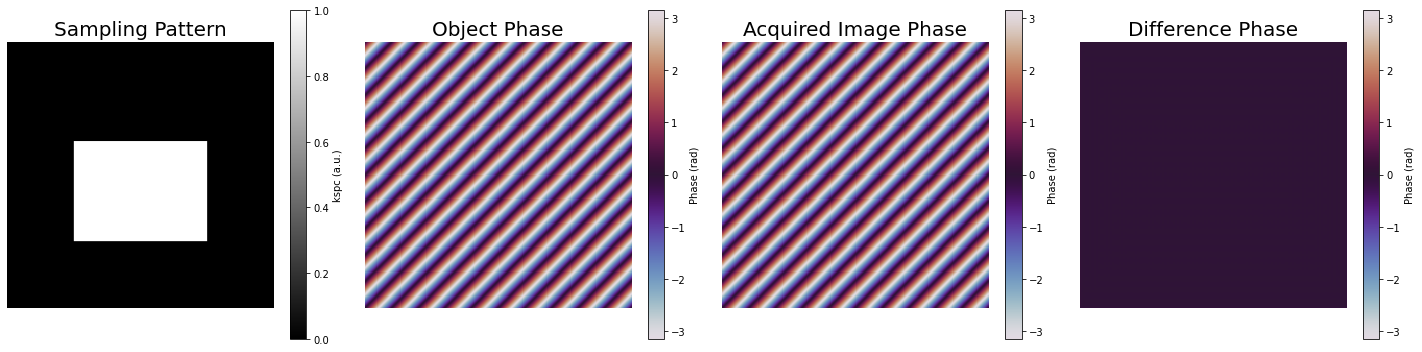

Centered, same # of Ky lines sampled as above PF 


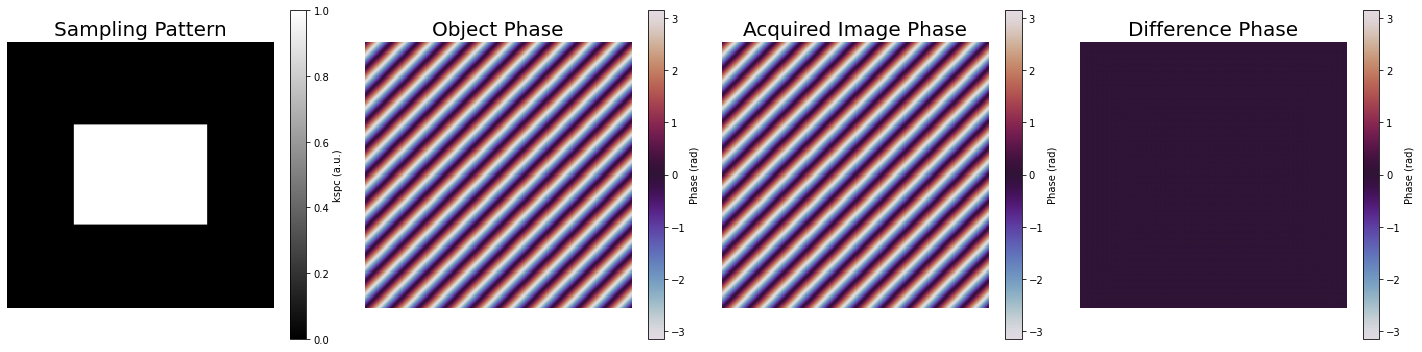

In [29]:

# Example well-preserved phase
starting_size = 256
pattern_size_x = 128
pattern_size_y = 128
ESP = 0.68
partial_fourier = 6/8
rate_of_change_values = 10
print('Partial Fourier')
visualize_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, ESP, partial_fourier, rate_of_change_values)

print('Centered, same # of Ky lines sampled as above PF ')

pattern_size_y = int(partial_fourier * pattern_size_y)
partial_fourier = 8/8
visualize_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, ESP, partial_fourier, rate_of_change_values)



Partial Fourier


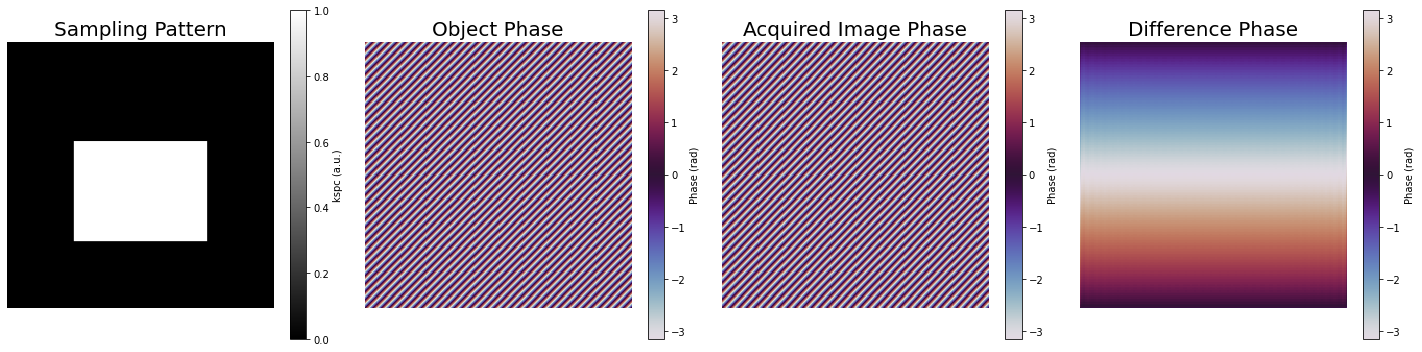

Centered, same # of Ky lines sampled as above PF 


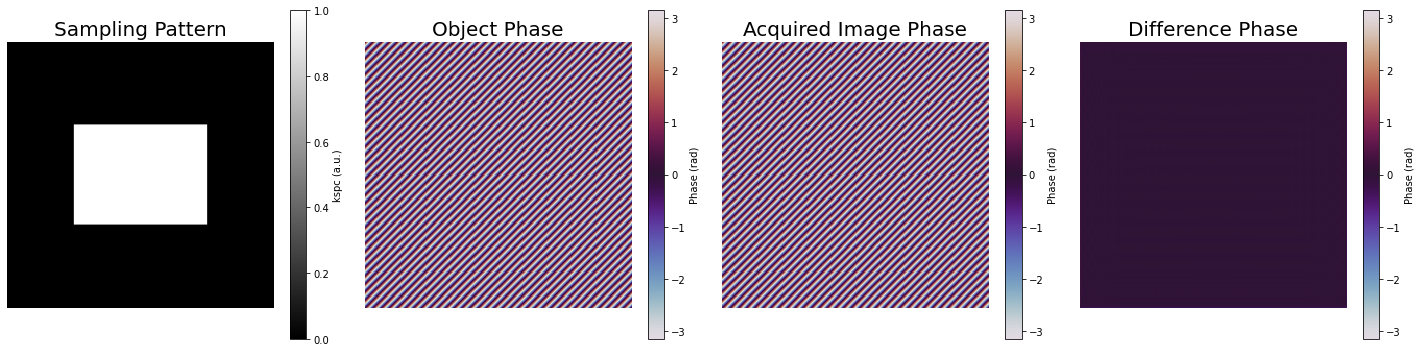

In [30]:
rate_of_change_values = 33
# Example well-preserved phase
starting_size = 256
pattern_size_x = 128
pattern_size_y = 128
ESP = 0.68
partial_fourier = 6/8

print('Partial Fourier')
visualize_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, ESP, partial_fourier, rate_of_change_values)

print('Centered, same # of Ky lines sampled as above PF ')

pattern_size_y = int(partial_fourier * pattern_size_y)
partial_fourier = 8/8
visualize_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, ESP, partial_fourier, rate_of_change_values)



# Load in Real Data

In [2]:
from Data_Import import *
from Data_Sorting import *
import os
import glob

In [3]:
NifTi_path = glob.glob(os.path.join('Original/','*.nii'))[0]
b_values_path = glob.glob(os.path.join('Original/','*.bvals'))[0]
b_vectors_path = glob.glob(os.path.join('Original/','*.bvecs'))[0]
header_path = glob.glob(os.path.join('Original/','*.header'))[0]

In [4]:
[NifTi, bvals, bvecs,_,_,_] = NifTi_Reader(NifTi_path, b_values_path = b_values_path , b_vectors_path = b_vectors_path, header_path = header_path, info = 'ON')
images_sorted, bvals_sorted, bvecs_sorted = stacked2sorted(NifTi,bvals,bvecs)
images_sorted.shape
bvals

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


array([  0., 350., 350., 350., 350., 350., 350., 350., 350., 350., 350.,
       350., 350.,   0., 350., 350., 350., 350., 350., 350., 350., 350.,
       350., 350., 350., 350.,   0., 350., 350., 350., 350., 350., 350.,
       350., 350., 350., 350., 350., 350.,   0., 350., 350., 350., 350.,
       350., 350., 350., 350., 350., 350., 350., 350.,   0., 350., 350.,
       350., 350., 350., 350., 350., 350., 350., 350., 350., 350.,   0.,
       350., 350., 350., 350., 350., 350., 350., 350., 350., 350., 350.,
       350.,   0., 350., 350., 350., 350., 350., 350., 350., 350., 350.,
       350., 350., 350.])

In [84]:
diff_dir = 3
avg = 1

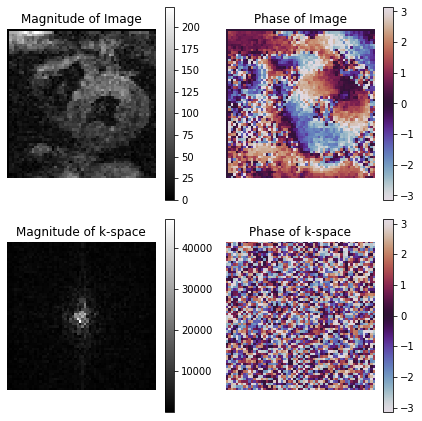

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming test_img and kspc are already defined
test_img = np.squeeze(images_sorted[:,:,0,diff_dir,avg])
kspc = fft2c(test_img)

# Plot the magnitude and phase of the image
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
plt.imshow(np.abs(test_img), cmap='gray',interpolation = 'nearest')
plt.title('Magnitude of Image')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(np.angle(test_img), cmap='twilight',interpolation = 'nearest')
plt.title('Phase of Image')
plt.colorbar()
plt.axis('off')

# Plot the magnitude and phase of the k-space data
plt.subplot(2, 2, 3)
plt.imshow(np.abs(kspc), cmap='gray',interpolation = 'nearest')
plt.title('Magnitude of k-space')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(np.angle(kspc), cmap='twilight',interpolation = 'nearest')
plt.title('Phase of k-space')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()



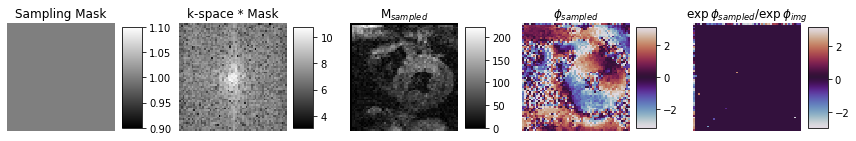

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming starting_size, pattern_size_x, pattern_size_y, partial_fourier, kspc, and sampling_pattern are already defined
starting_size = 60
pattern_size_x = 60
pattern_size_y = 60
partial_fourier = 1
sampling_pattern = define_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, partial_fourier)

sampled_kspc = kspc * sampling_pattern
sampled_image = ifft2c(sampled_kspc)

# Plot the sampling mask
plt.figure(figsize=(12, 8))


plt.subplot(1, 5, 1)
plt.imshow(sampling_pattern, cmap='gray',interpolation = 'nearest')
plt.title('Sampling Mask')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')

# Plot the k-space multiplied by the mask on a log scale
plt.subplot(1, 5, 2)
plt.imshow(np.log(np.abs(sampled_kspc) + 1e-9), cmap='gray',interpolation = 'nearest')
plt.title('k-space * Mask')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')

# Plot the magnitude and phase of the recovered image
plt.subplot(1, 5, 3)
plt.imshow(np.abs(sampled_image), cmap='gray',interpolation = 'nearest')
plt.title('M$_{sampled}$')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(np.angle(sampled_image), cmap='twilight',interpolation = 'nearest')
plt.title('$\phi_{sampled}$')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')


# Plot the complex division of the original phase and the sampled phase
plt.subplot(1, 5, 5)
complex_division =  np.exp(1j*np.angle(sampled_image)) / np.exp(1j*np.angle(test_img))
plt.imshow(np.angle(complex_division), cmap='twilight',interpolation = 'nearest')
plt.title('$\exp{\phi_{sampled}}/\exp{\phi_{img}} $')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')


plt.tight_layout()
plt.show()


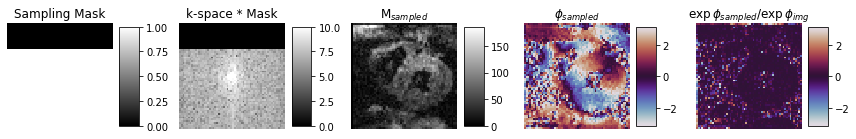

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming starting_size, pattern_size_x, pattern_size_y, partial_fourier, kspc, and sampling_pattern are already defined
starting_size = 60
pattern_size_x = 60
pattern_size_y = 60
partial_fourier = 6/8
sampling_pattern = define_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, partial_fourier)

sampled_kspc = kspc * sampling_pattern
sampled_image = ifft2c(sampled_kspc)


# Plot the sampling mask
plt.figure(figsize=(12, 8))

plt.subplot(1, 5, 1)
plt.imshow(sampling_pattern, cmap='gray',interpolation = 'nearest')
plt.title('Sampling Mask')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')

# Plot the k-space multiplied by the mask on a log scale
plt.subplot(1, 5, 2)
plt.imshow(np.log(np.abs(sampled_kspc) + 1e-9), cmap='gray',interpolation = 'nearest',vmin = 0,vmax = 10)
plt.title('k-space * Mask')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')

# Plot the magnitude and phase of the recovered image
plt.subplot(1, 5, 3)
plt.imshow(np.abs(sampled_image), cmap='gray',interpolation = 'nearest')
plt.title('M$_{sampled}$')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(np.angle(sampled_image), cmap='twilight',interpolation = 'nearest',vmin = -np.pi,vmax = np.pi)
plt.title('$\phi_{sampled}$')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')


# Plot the complex division of the original phase and the sampled phase
plt.subplot(1, 5, 5)
complex_division =  np.exp(1j*np.angle(sampled_image)) / np.exp(1j*np.angle(test_img))
plt.imshow(np.angle(complex_division), cmap='twilight',interpolation = 'nearest',vmin = -np.pi,vmax = np.pi)
plt.title('$\exp{\phi_{sampled}}/\exp{\phi_{img}} $')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')




plt.tight_layout()
plt.show()


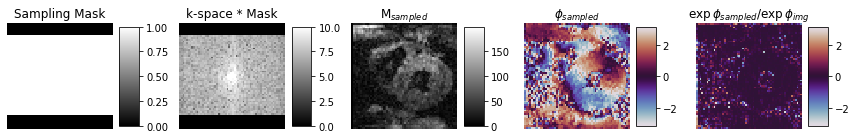

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming starting_size, pattern_size_x, pattern_size_y, partial_fourier, kspc, and sampling_pattern are already defined
starting_size = 60
pattern_size_x = 60
pattern_size_y = 45
partial_fourier = 8/8
sampling_pattern = define_sampling_pattern(starting_size, pattern_size_x, pattern_size_y, partial_fourier)

sampled_kspc = kspc * sampling_pattern
sampled_image = ifft2c(sampled_kspc)

# Plot the sampling mask
plt.figure(figsize=(12, 8))

plt.subplot(1, 5, 1)
plt.imshow(sampling_pattern, cmap='gray',interpolation = 'nearest')
plt.title('Sampling Mask')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')

# Plot the k-space multiplied by the mask on a log scale
plt.subplot(1, 5, 2)
plt.imshow(np.log(np.abs(sampled_kspc) + 1e-9), cmap='gray',interpolation = 'nearest',vmin = 0,vmax = 10)
plt.title('k-space * Mask')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')

# Plot the magnitude and phase of the recovered image
plt.subplot(1, 5, 3)
plt.imshow(np.abs(sampled_image), cmap='gray',interpolation = 'nearest')
plt.title('M$_{sampled}$')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(np.angle(sampled_image), cmap='twilight',interpolation = 'nearest',vmin = -np.pi,vmax = np.pi)
plt.title('$\phi_{sampled}$')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')


# Plot the complex division of the original phase and the sampled phase
plt.subplot(1, 5, 5)
complex_division =  np.exp(1j*np.angle(sampled_image)) / np.exp(1j*np.angle(test_img))
plt.imshow(np.angle(complex_division), cmap='twilight',interpolation = 'nearest',vmin = -np.pi,vmax = np.pi)
plt.title('$\exp{\phi_{sampled}}/\exp{\phi_{img}} $')
plt.colorbar(aspect=5)  # Adjust aspect ratio here
plt.axis('off')


plt.tight_layout()
plt.show()


# Load in Real Data - Real PF vs. FF same parameters, same volunteer, just difference is in PF vs. FF 

In [20]:
from Data_Import import *
from Data_Sorting import *
import os
import glob

def fft2c(ki):
    im = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(ki)))
    return im

def ifft2c(im):
    ki = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(im)))
    return ki


In [21]:
start = '/Volumes/T7/Partial_Fourier/CDTI_Full_Fourier'

NifTi_path = glob.glob(os.path.join(start,'*Original/','*.nii'))[0]
b_values_path = glob.glob(os.path.join(start,'*Original/','*.bvals'))[0]
b_vectors_path = glob.glob(os.path.join(start,'*Original/','*.bvecs'))[0]
header_path = glob.glob(os.path.join(start,'*Original/','*.header'))[0]

[NifTi, bvals, bvecs,_,_,_] = NifTi_Reader(NifTi_path, b_values_path = b_values_path , b_vectors_path = b_vectors_path, header_path = header_path, info = 'ON')
images_sorted, bvals_sorted, bvecs_sorted = stacked2sorted(NifTi,bvals,bvecs)
images_sorted.shape

Full_Fourier = images_sorted

In [22]:

start = '/Volumes/T7/Partial_Fourier/CDTI_Partial_Fourier'

NifTi_path = glob.glob(os.path.join(start,'*Original/','*.nii'))[0]
b_values_path = glob.glob(os.path.join(start,'*Original/','*.bvals'))[0]
b_vectors_path = glob.glob(os.path.join(start,'*Original/','*.bvecs'))[0]
header_path = glob.glob(os.path.join(start,'*Original/','*.header'))[0]

[NifTi, bvals, bvecs,_,_,_] = NifTi_Reader(NifTi_path, b_values_path = b_values_path , b_vectors_path = b_vectors_path, header_path = header_path, info = 'ON')
images_sorted, bvals_sorted, bvecs_sorted = stacked2sorted(NifTi,bvals,bvecs)
images_sorted.shape

Partial_Fourier = images_sorted



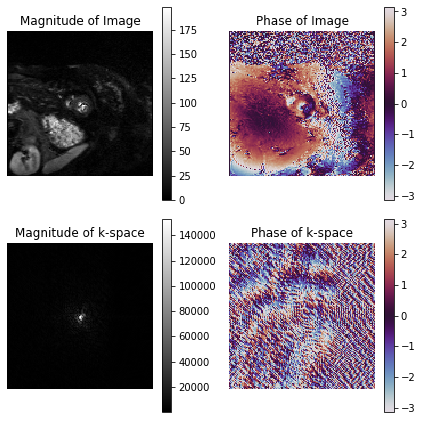

In [23]:
import numpy as np
import matplotlib.pyplot as plt

diff_dir = 0
avg = 0

# Assuming test_img and kspc are already defined
test_img = np.squeeze(Partial_Fourier[:,:,0,diff_dir,avg])
kspc = fft2c(test_img)

# Plot the magnitude and phase of the image
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
plt.imshow(np.abs(test_img), cmap='gray',interpolation = 'nearest')
plt.title('Magnitude of Image')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(np.angle(test_img), cmap='twilight',interpolation = 'nearest')
plt.title('Phase of Image')
plt.colorbar()
plt.axis('off')

# Plot the magnitude and phase of the k-space data
plt.subplot(2, 2, 3)
plt.imshow(np.abs(kspc), cmap='gray',interpolation = 'nearest')
plt.title('Magnitude of k-space')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(np.angle(kspc), cmap='twilight',interpolation = 'nearest')
plt.title('Phase of k-space')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()



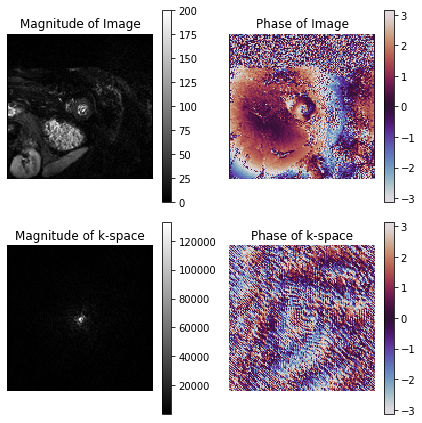

In [24]:
import numpy as np
import matplotlib.pyplot as plt

diff_dir = 0
avg = 0

# Assuming test_img and kspc are already defined
test_img = np.squeeze(Full_Fourier[:,:,0,diff_dir,avg])
kspc = fft2c(test_img)

# Plot the magnitude and phase of the image
plt.figure(figsize=(6, 6))

plt.subplot(2, 2, 1)
plt.imshow(np.abs(test_img), cmap='gray',interpolation = 'nearest')
plt.title('Magnitude of Image')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(np.angle(test_img), cmap='twilight',interpolation = 'nearest')
plt.title('Phase of Image')
plt.colorbar()
plt.axis('off')

# Plot the magnitude and phase of the k-space data
plt.subplot(2, 2, 3)
plt.imshow(np.abs(kspc), cmap='gray',interpolation = 'nearest')
plt.title('Magnitude of k-space')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(np.angle(kspc), cmap='twilight',interpolation = 'nearest')
plt.title('Phase of k-space')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

<ipython-input-43-4992de760c1d>:10: RuntimeWarning: divide by zero encountered in divide
  test_img_ratio = test_img_full / test_img_partial
<ipython-input-43-4992de760c1d>:10: RuntimeWarning: invalid value encountered in divide
  test_img_ratio = test_img_full / test_img_partial


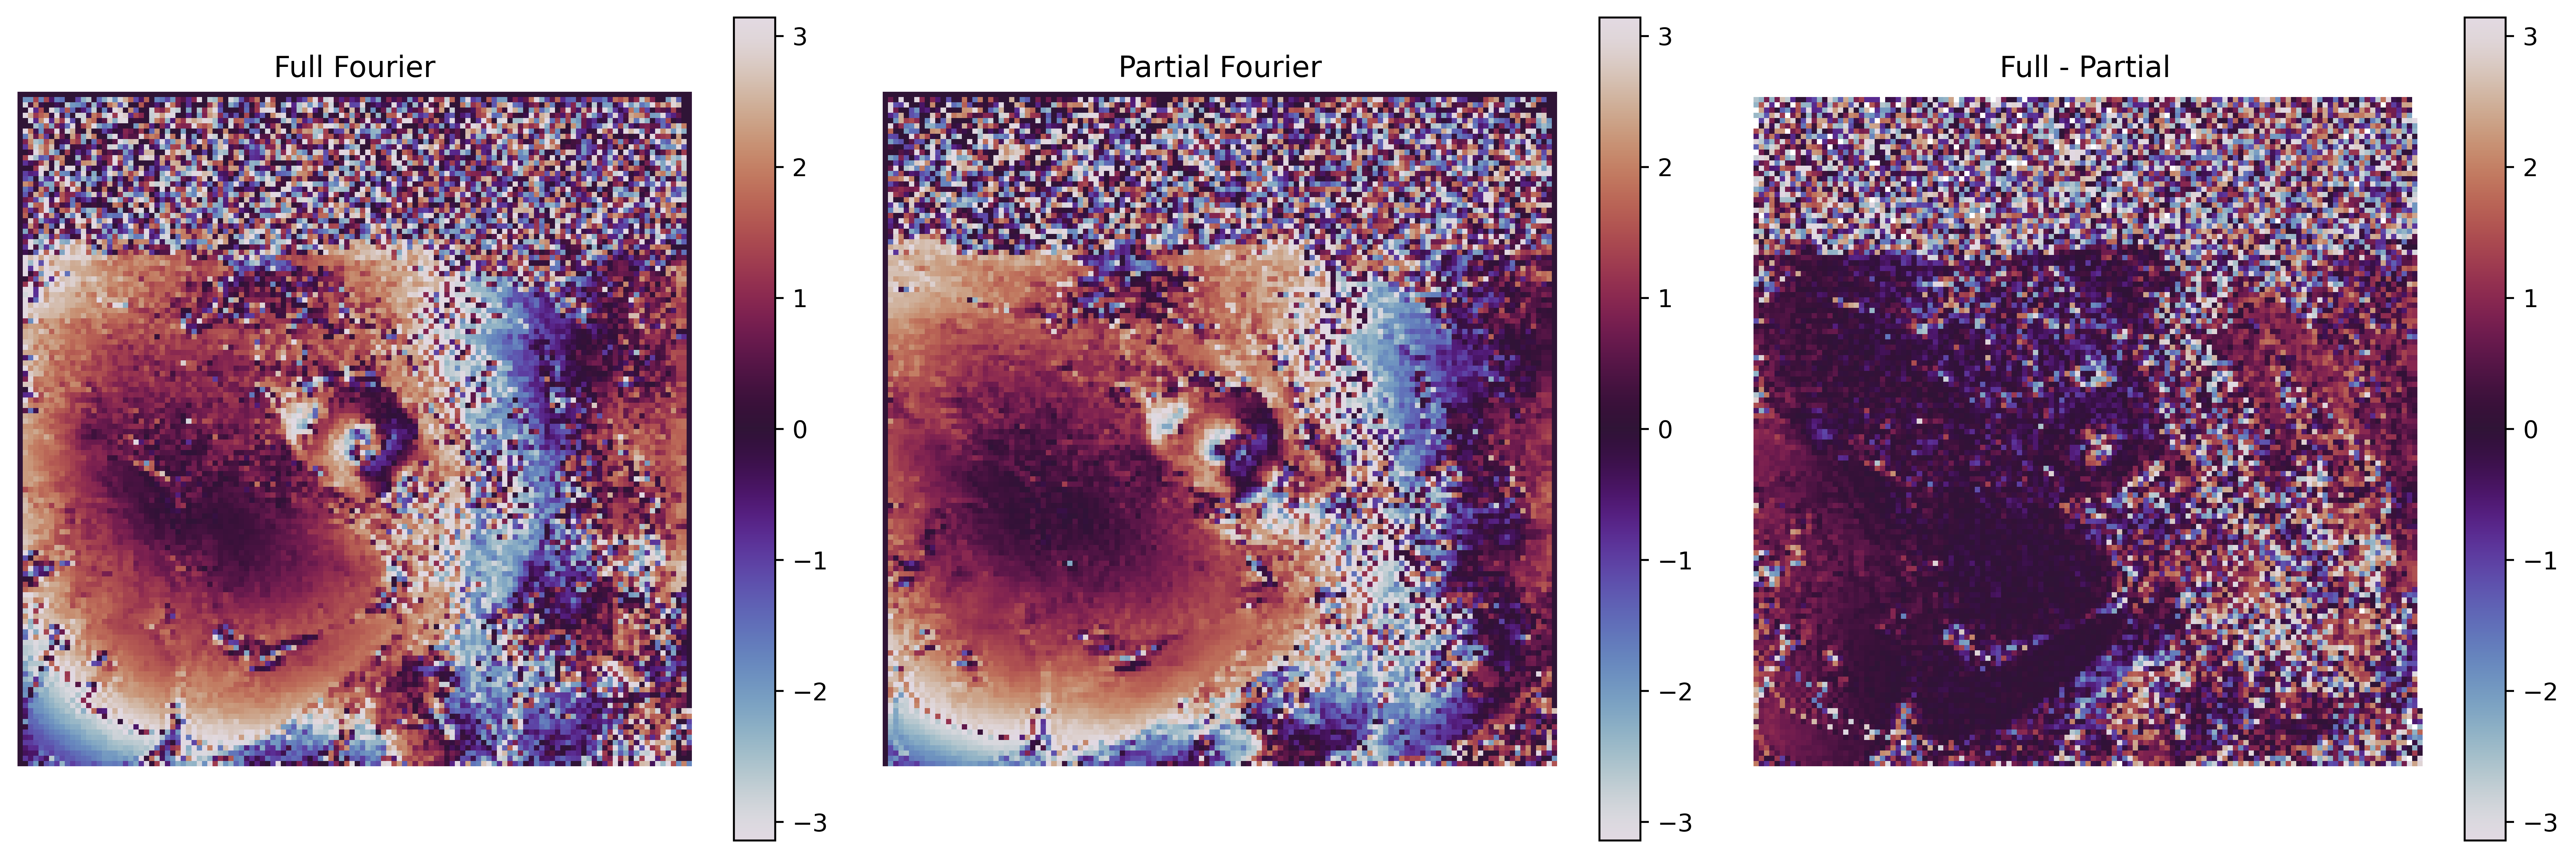

In [43]:
import numpy as np
import matplotlib.pyplot as plt

diff_dir = 0
avg = 0

# Assuming test_img and kspc are already defined
test_img_full = np.squeeze(Full_Fourier[:,:,0,diff_dir,avg])
test_img_partial = np.squeeze(Partial_Fourier[:,:,0,diff_dir,avg])
test_img_ratio = test_img_full / test_img_partial

fig, axes = plt.subplots(1, 3, figsize=(15, 5),dpi = 500)

# Plot for Full Fourier
im = axes[0].imshow(np.angle(test_img_full), cmap='twilight', interpolation='nearest')
fig.colorbar(im, ax=axes[0])
axes[0].axis('off')
axes[0].set_title('Full Fourier')

# Plot for Partial Fourier
im = axes[1].imshow(np.angle(test_img_partial), cmap='twilight', interpolation='nearest')
fig.colorbar(im, ax=axes[1])
axes[1].axis('off')
axes[1].set_title('Partial Fourier')

# Plot for Ratio
im = axes[2].imshow(np.angle(test_img_ratio), cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
fig.colorbar(im, ax=axes[2])
axes[2].axis('off')
axes[2].set_title('Full - Partial')

plt.tight_layout()
plt.show()
